In [1]:
suppressPackageStartupMessages({
  library(scater)
  library(scran)
  library(tidyverse)
  library(Seurat)
  library(patchwork)
  library(OmnipathR)
  library(nichenetr)


})
rm(list = ls())
######################
# Smartseq2 CD45 All
######################
sce <- readRDS("../../data/expression/sce/sce_Smartseq2_scHCC-CD45_featureCounts_qc_clustered_analysed.rds")




In [2]:
sce <- sce[rowData(sce)$Biotype == 'protein_coding',]
keep <- calculateAverage(sce) > 1
sce <- logNormCounts(sce[keep,])

In [3]:
sub <-  sce[, grepl("^CAF", sce$celltype)]
markers <- findMarkers(sub, groups = sub$celltype, direction = 'up', lfc = 1)
genes_of_interest = markers[['CAF_C01-FAP']]
genes_of_interest <- rownames(genes_of_interest)[genes_of_interest$FDR < 0.1]

In [4]:
genes_of_interest <- c(genes_of_interest, 'HGF', 'FAP')

In [5]:
markers[['CAF_C01-FAP']]['CCL21',]

DataFrame with 1 row and 5 columns
            Top     p.value         FDR summary.logFC logFC.CAF_C02-CD36
      <integer>   <numeric>   <numeric>     <numeric>          <numeric>
CCL21        84 4.08578e-06 0.000702316       3.82328            3.82328

In [7]:
ligand_target_matrix = readRDS(url("https://zenodo.org/record/3260758/files/ligand_target_matrix.rds"))
lr_network = readRDS(url("https://zenodo.org/record/3260758/files/lr_network.rds"))
weighted_networks = readRDS(url("https://zenodo.org/record/3260758/files/weighted_networks.rds"))
weighted_networks_lr = weighted_networks$lr_sig %>% inner_join(lr_network %>% distinct(from,to), by = c("from","to"))

# CAF expressed genes

In [8]:
expressed_genes_receiver <- rownames(sce)[calculateAverage(sce[, sce$celltype == 'CAF_C01-FAP'], assay.type = 'logcounts') > 2]

In [9]:
all_ligands <- unique(lr_network$from)
background_expressed_genes = expressed_genes_receiver %>% .[. %in% rownames(ligand_target_matrix)]

In [10]:
ligand_activities = predict_ligand_activities(geneset = genes_of_interest, background_expressed_genes = background_expressed_genes, ligand_target_matrix = ligand_target_matrix, potential_ligands = all_ligands)

Warning message in evaluate_target_prediction(setting, ligand_target_matrix, ligands_position):
“all target gene probability score predictions have same value”
Warning message in cor(prediction, response):
“the standard deviation is zero”
Warning message in cor(prediction, response, method = "s"):
“the standard deviation is zero”


In [21]:
readr::write_tsv(ligand_activities, file = "./out/ligand_activities_CAF_FAP.tsv")

Warning message:
“Removed 1 rows containing missing values (geom_point).”


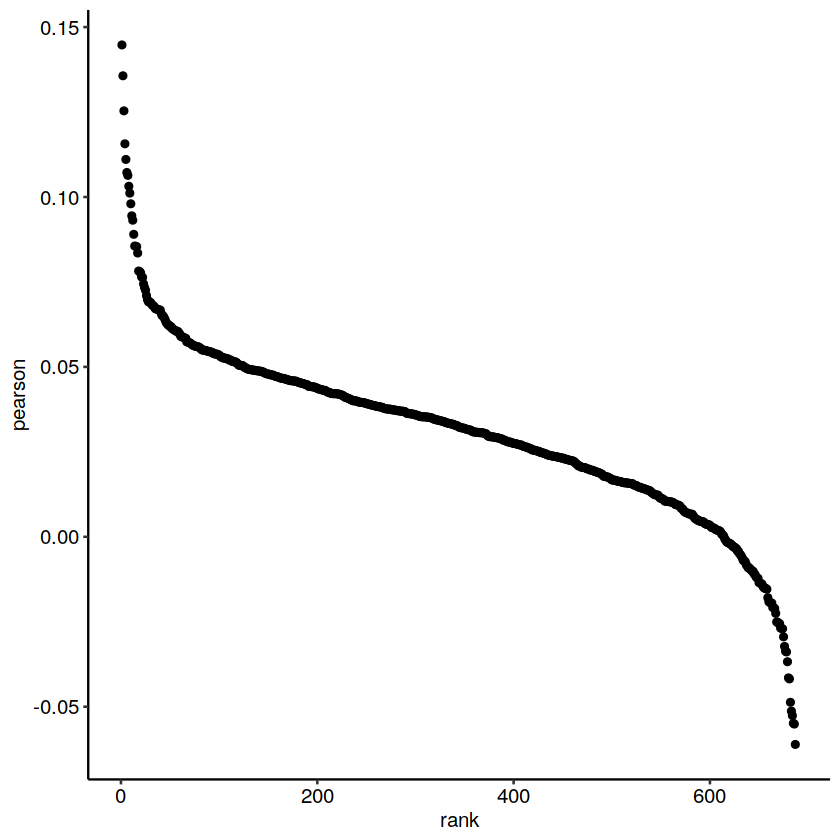

In [20]:
ligand_activities %>% mutate(rank =1:n()) %>%
    ggplot(aes(x = rank , y = pearson)) +
        geom_point() +
        ggpubr::theme_pubr() 

In [11]:
ligand_activities <- ligand_activities %>% arrange(-pearson) 
best_upstream_ligands = ligand_activities %>% top_n(30, pearson) %>% arrange(-pearson) %>% pull(test_ligand)

In [12]:
active_ligand_target_links_df = best_upstream_ligands %>% 
lapply(get_weighted_ligand_target_links,geneset = genes_of_interest, ligand_target_matrix = ligand_target_matrix, n = 250) %>% 
bind_rows()

active_ligand_target_links_df <- active_ligand_target_links_df[!is.na(active_ligand_target_links_df$weight),]

In [13]:
active_ligand_target_links = prepare_ligand_target_visualization(ligand_target_df = active_ligand_target_links_df, ligand_target_matrix = ligand_target_matrix)

In [14]:
active_ligand_target_links_df[active_ligand_target_links_df$target == 'TIMP1',][['ligand']]

[1] "TGFB1"  "APOE"   "IL1B"   "POMC"   "EDN1"   "TNF"    "AGT"    "EGF"   
 [9] "FGF2"   "SPP1"   "IL1A"   "FGF1"   "CTGF"   "IL13"   "SELPLG"

In [281]:
readr::write_tsv(active_ligand_target_links_df, file = "./out/nichenet_ligand_target_weight.tsv")

In [15]:
active_ligand_target_links_df[active_ligand_target_links_df$target == 'CCL19',]

ligand,target,weight
<chr>,<chr>,<dbl>
APOE,CCL19,0.006460860
TNF,CCL19,0.008979892
CCL1,CCL19,0.001386649
TNFSF14,CCL19,0.003398137
TNFSF12,CCL19,0.003213536


In [159]:
active_ligand_target_links_df[active_ligand_target_links_df$target == 'HGF',]

ligand,target,weight
<chr>,<chr>,<dbl>
TGFB1,HGF,0.004975455
TNF,HGF,0.004687197
FGF2,HGF,0.006497497
TNFSF12,HGF,0.002436292


In [161]:
active_ligand_target_links_df[active_ligand_target_links_df$target == 'FAP',]

ligand,target,weight
<chr>,<chr>,<dbl>


In [160]:
active_ligand_target_links_df[active_ligand_target_links_df$target == 'CCL21',]

ligand,target,weight
<chr>,<chr>,<dbl>
TNFSF12,CCL21,0.003722708


In [162]:
active_ligand_target_links_df[active_ligand_target_links_df$target == 'CXCL12',]

ligand,target,weight
<chr>,<chr>,<dbl>
APOE,CXCL12,0.004395159
IL1B,CXCL12,0.004730518
EGF,CXCL12,0.004472141
FGF2,CXCL12,0.002419423
CCL1,CXCL12,0.001597068
BMP2,CXCL12,0.002519170


In [99]:
setdiff(order_targets, rownames(active_ligand_target_links))

[1] "LTBP4"   "BICC1"   "B4GALT1"

In [141]:
table(is.na(colnames(vis_ligand_target) ))


FALSE 
   34 

In [16]:
ligand_pearson_matrix = ligand_activities %>% select(pearson) %>% as.matrix() %>% magrittr::set_rownames(ligand_activities$test_ligand)

vis_ligand_pearson = ligand_pearson_matrix[order_ligands, ] %>% as.matrix(ncol = 1) %>% magrittr::set_colnames("Pearson")

ERROR: Error in h(simpleError(msg, call)): error in evaluating the argument 'x' in selecting a method for function 'as.matrix': object 'order_ligands' not found


In [250]:
dev.off()

null device 
          1

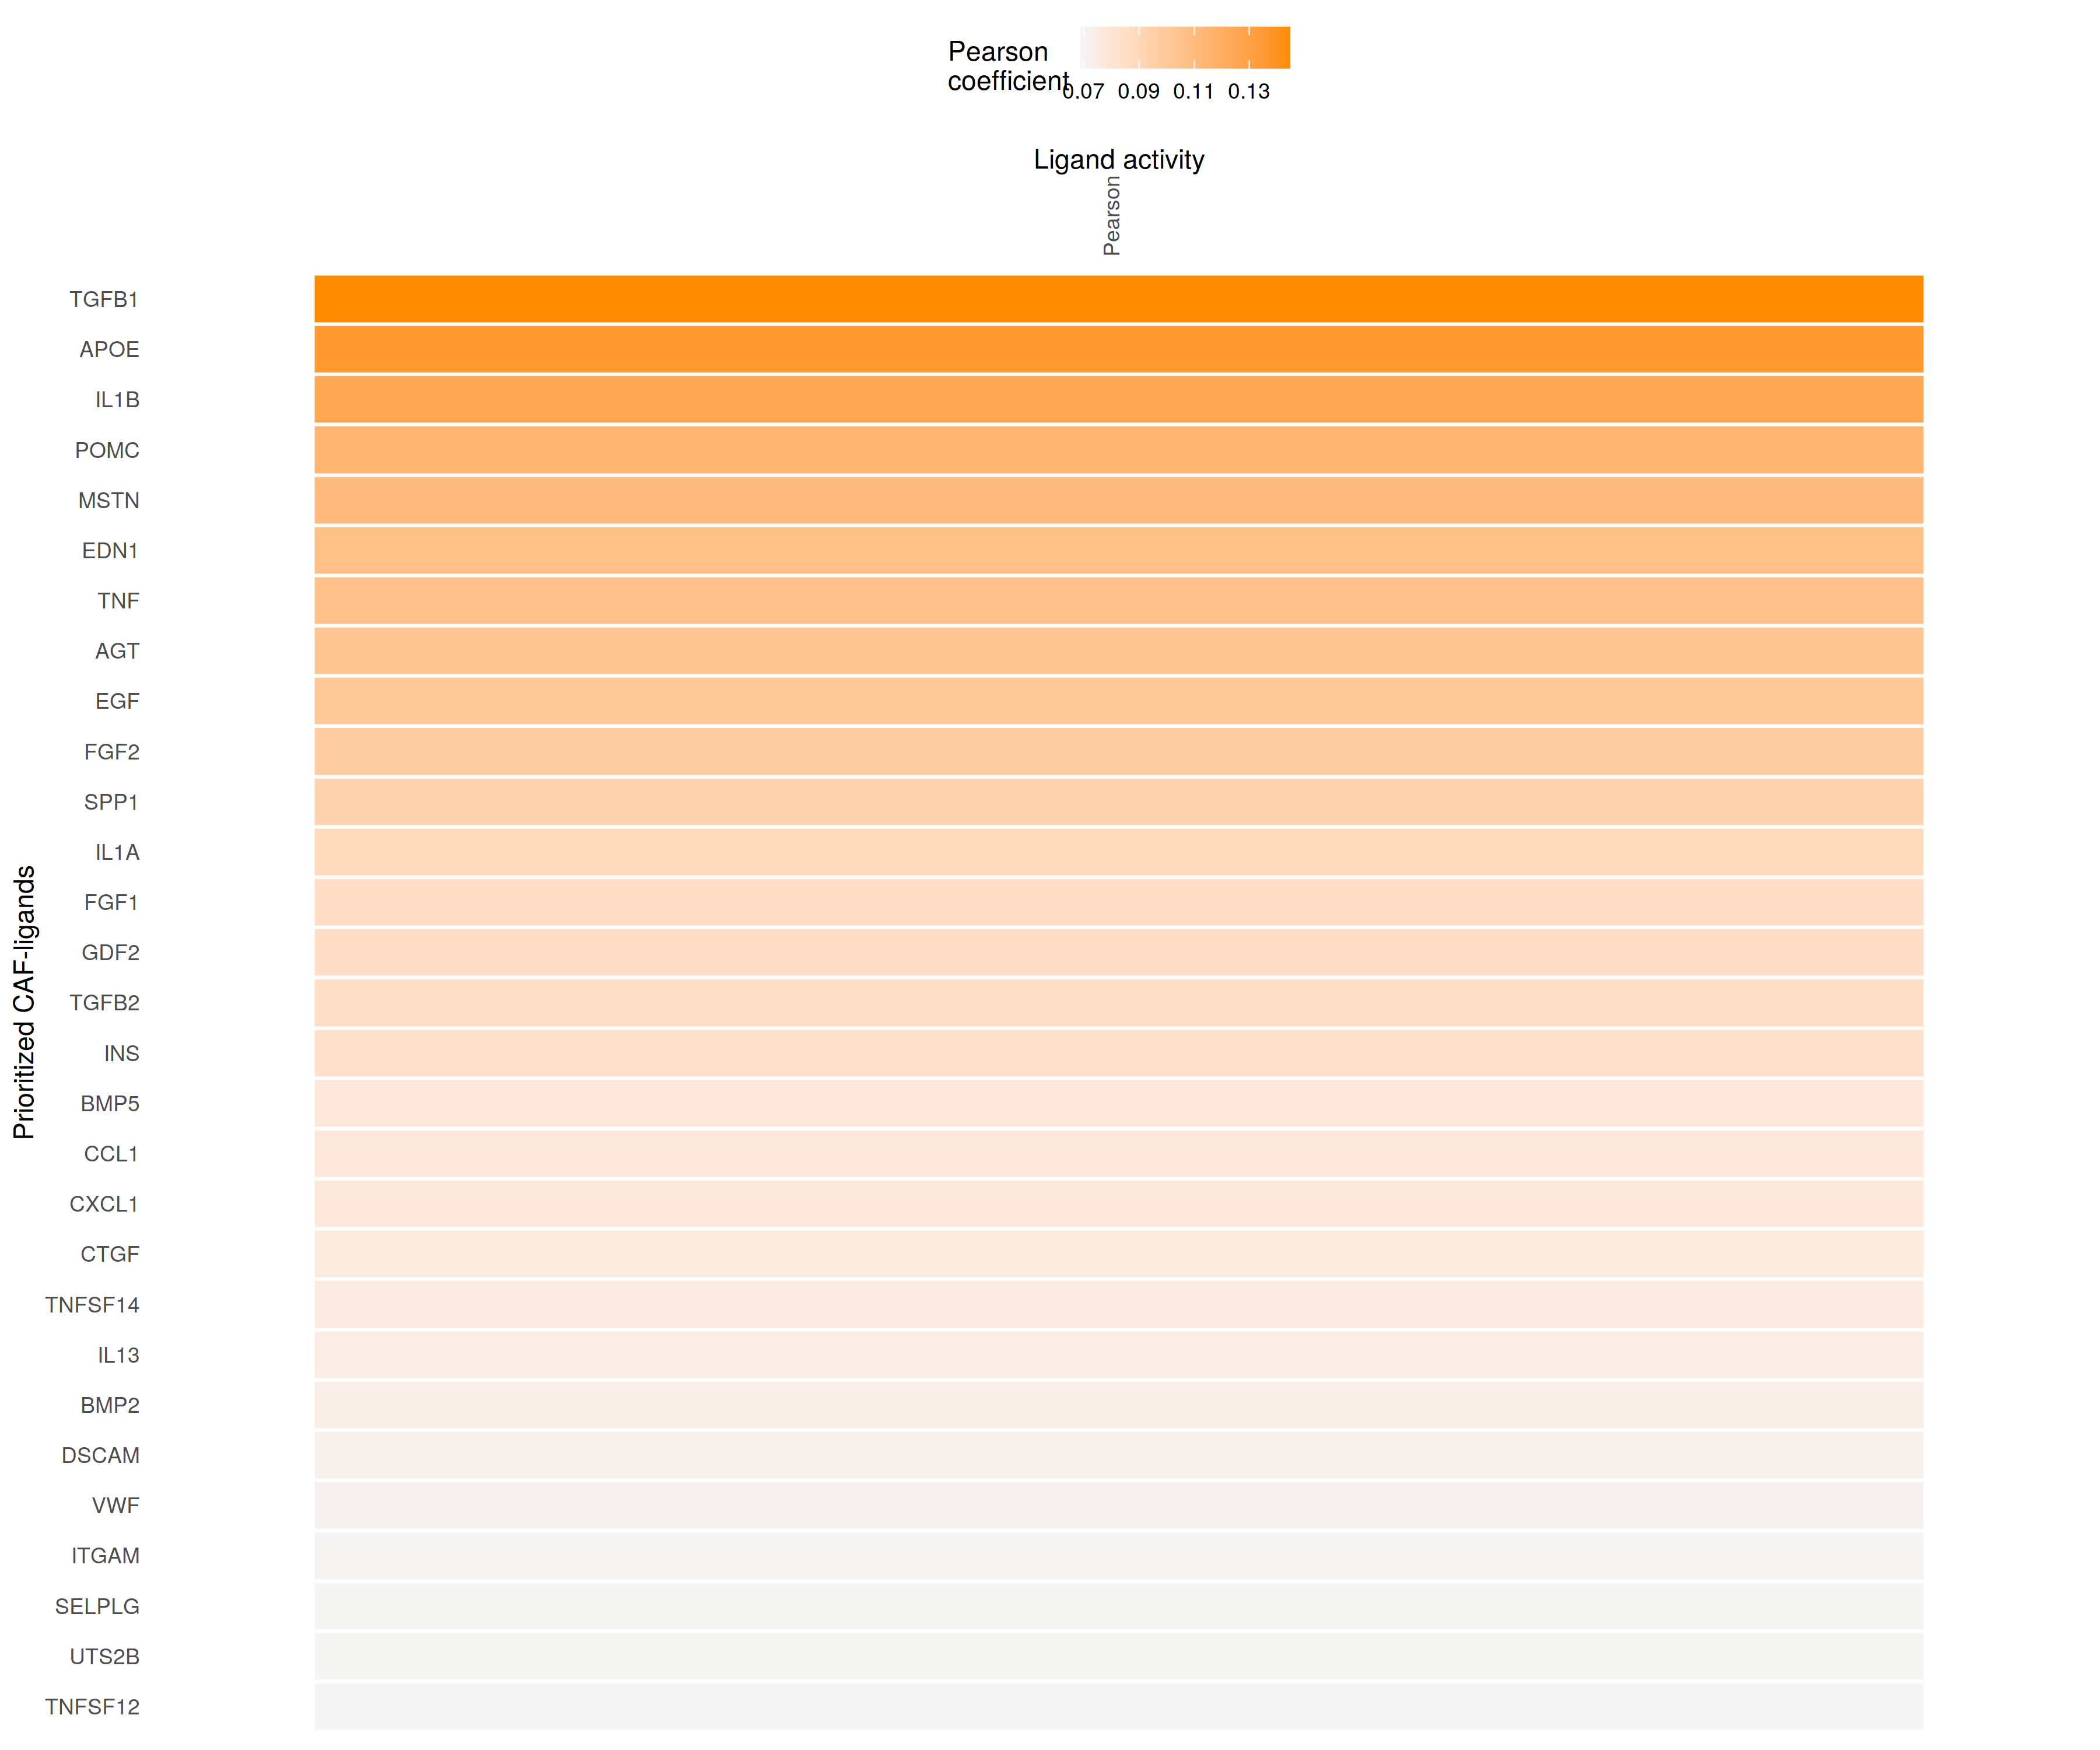

In [261]:
p_ligand_pearson = vis_ligand_pearson %>% make_heatmap_ggplot("Prioritized CAF-ligands","Ligand activity", color = "darkorange",legend_position = "top", x_axis_position = "top", legend_title = "Pearson\ncoefficient")
p_ligand_pearson

In [ ]:
mt <- vis_ligand_target
vis_ligand_target <- as.data.frame(vis_ligand_target) %>% 
    rownames_to_column('ligand') %>% 
    tidyr::pivot_longer(cols = -ligand, names_to = 'target', values_to = 'Reg') %>% 
    mutate(ligand = factor(ligand, levels = rownames(vis_ligand_target), ordered = TRUE), 
           target = factor(target, levels = colnames(vis_ligand_target), ordered = TRUE))

In [208]:
RColorBrewer::brewer.pal(n = 9, name = "Purples")

[1] "#FCFBFD" "#EFEDF5" "#DADAEB" "#BCBDDC" "#9E9AC8" "#807DBA" "#6A51A3"
[8] "#54278F" "#3F007D"

In [241]:
best_upstream_ligands

[1] "TGFB1"   "APOE"    "IL1B"    "POMC"    "MSTN"    "EDN1"    "TNF"    
 [8] "AGT"     "EGF"     "FGF2"    "DSC3"    "SPP1"    "IL1A"    "FGF1"   
[15] "GDF2"    "TGFB2"   "INS"     "BMP5"    "CCL1"    "CXCL1"   "CTGF"   
[22] "TNFSF14" "IL13"    "BMP2"    "DSCAM"   "VWF"     "ITGAM"   "SELPLG" 
[29] "UTS2B"   "TNFSF12"

In [274]:
p1 <- p_ligand_pearson + ylab("") +  p + plot_layout(widths = c(.1, 1.2)) 

In [276]:
ggsave(p1, filename = "../figures/Figure3/3A_Heatmap_nichenetr_to_FAP_CAF.pdf", height = 5, width = 10)

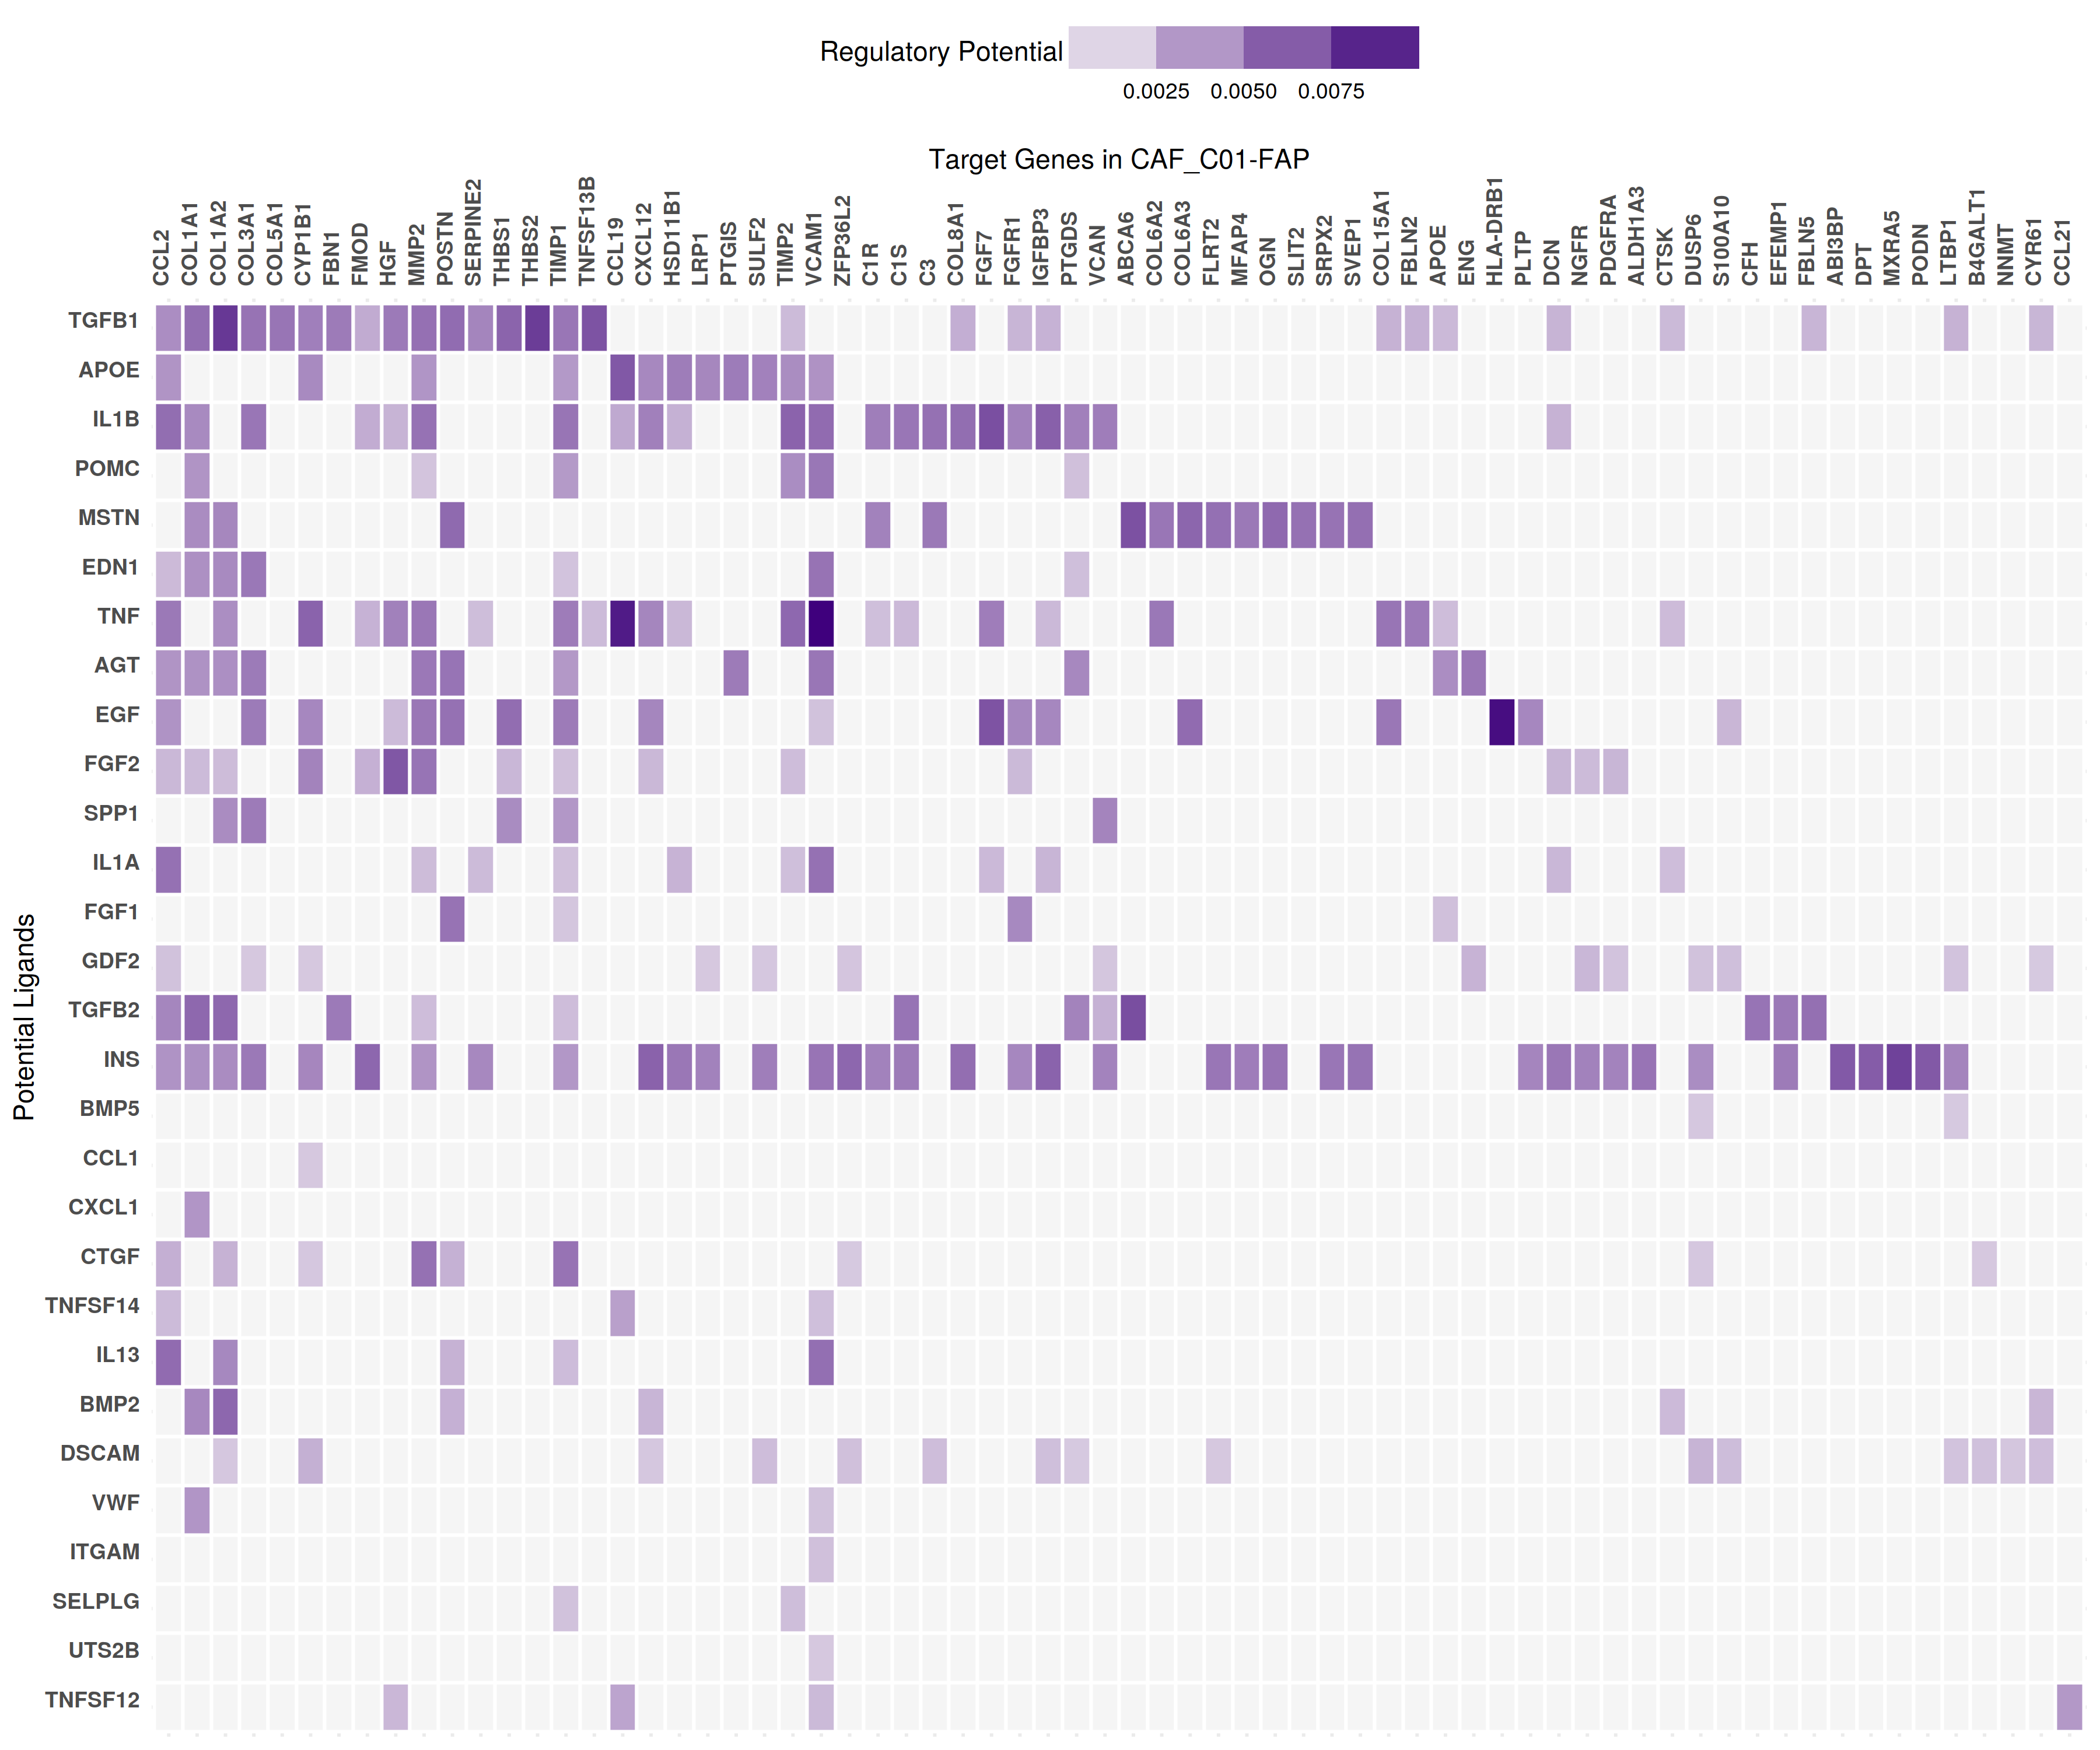

In [266]:
p <- ggplot(vis_ligand_target, aes(y = ligand, x = target, fill = Reg)) + 
        geom_tile(color = "white", size = 0.5) + 
        scale_fill_gradient(low = "whitesmoke", high = '#3F007D') + 
        scale_x_discrete(position = 'top') + 
        guides(fill = guide_colorsteps(direction = 'horizontal', title = 'Regulatory Potential', barwidth = 10, title.vjust = .75)) +
        xlab("Target Genes in CAF_C01-FAP") +
        ylab("Potential Ligands") +
        theme_minimal() + 
        theme(legend.position = 'top', axis.text.x = element_text(angle = 90, vjust = 1, hjust = 0, face = 'bold'), 
                               axis.text.y = element_text(angle = 0, vjust = 0, hjust = 1, face = 'bold'))
p
ggsave(p,filename =  "../figures/Figure3/3A_Heatmap_nichenetr_to_FAP_CAF.pdf", height = 4, width = 7)

Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.



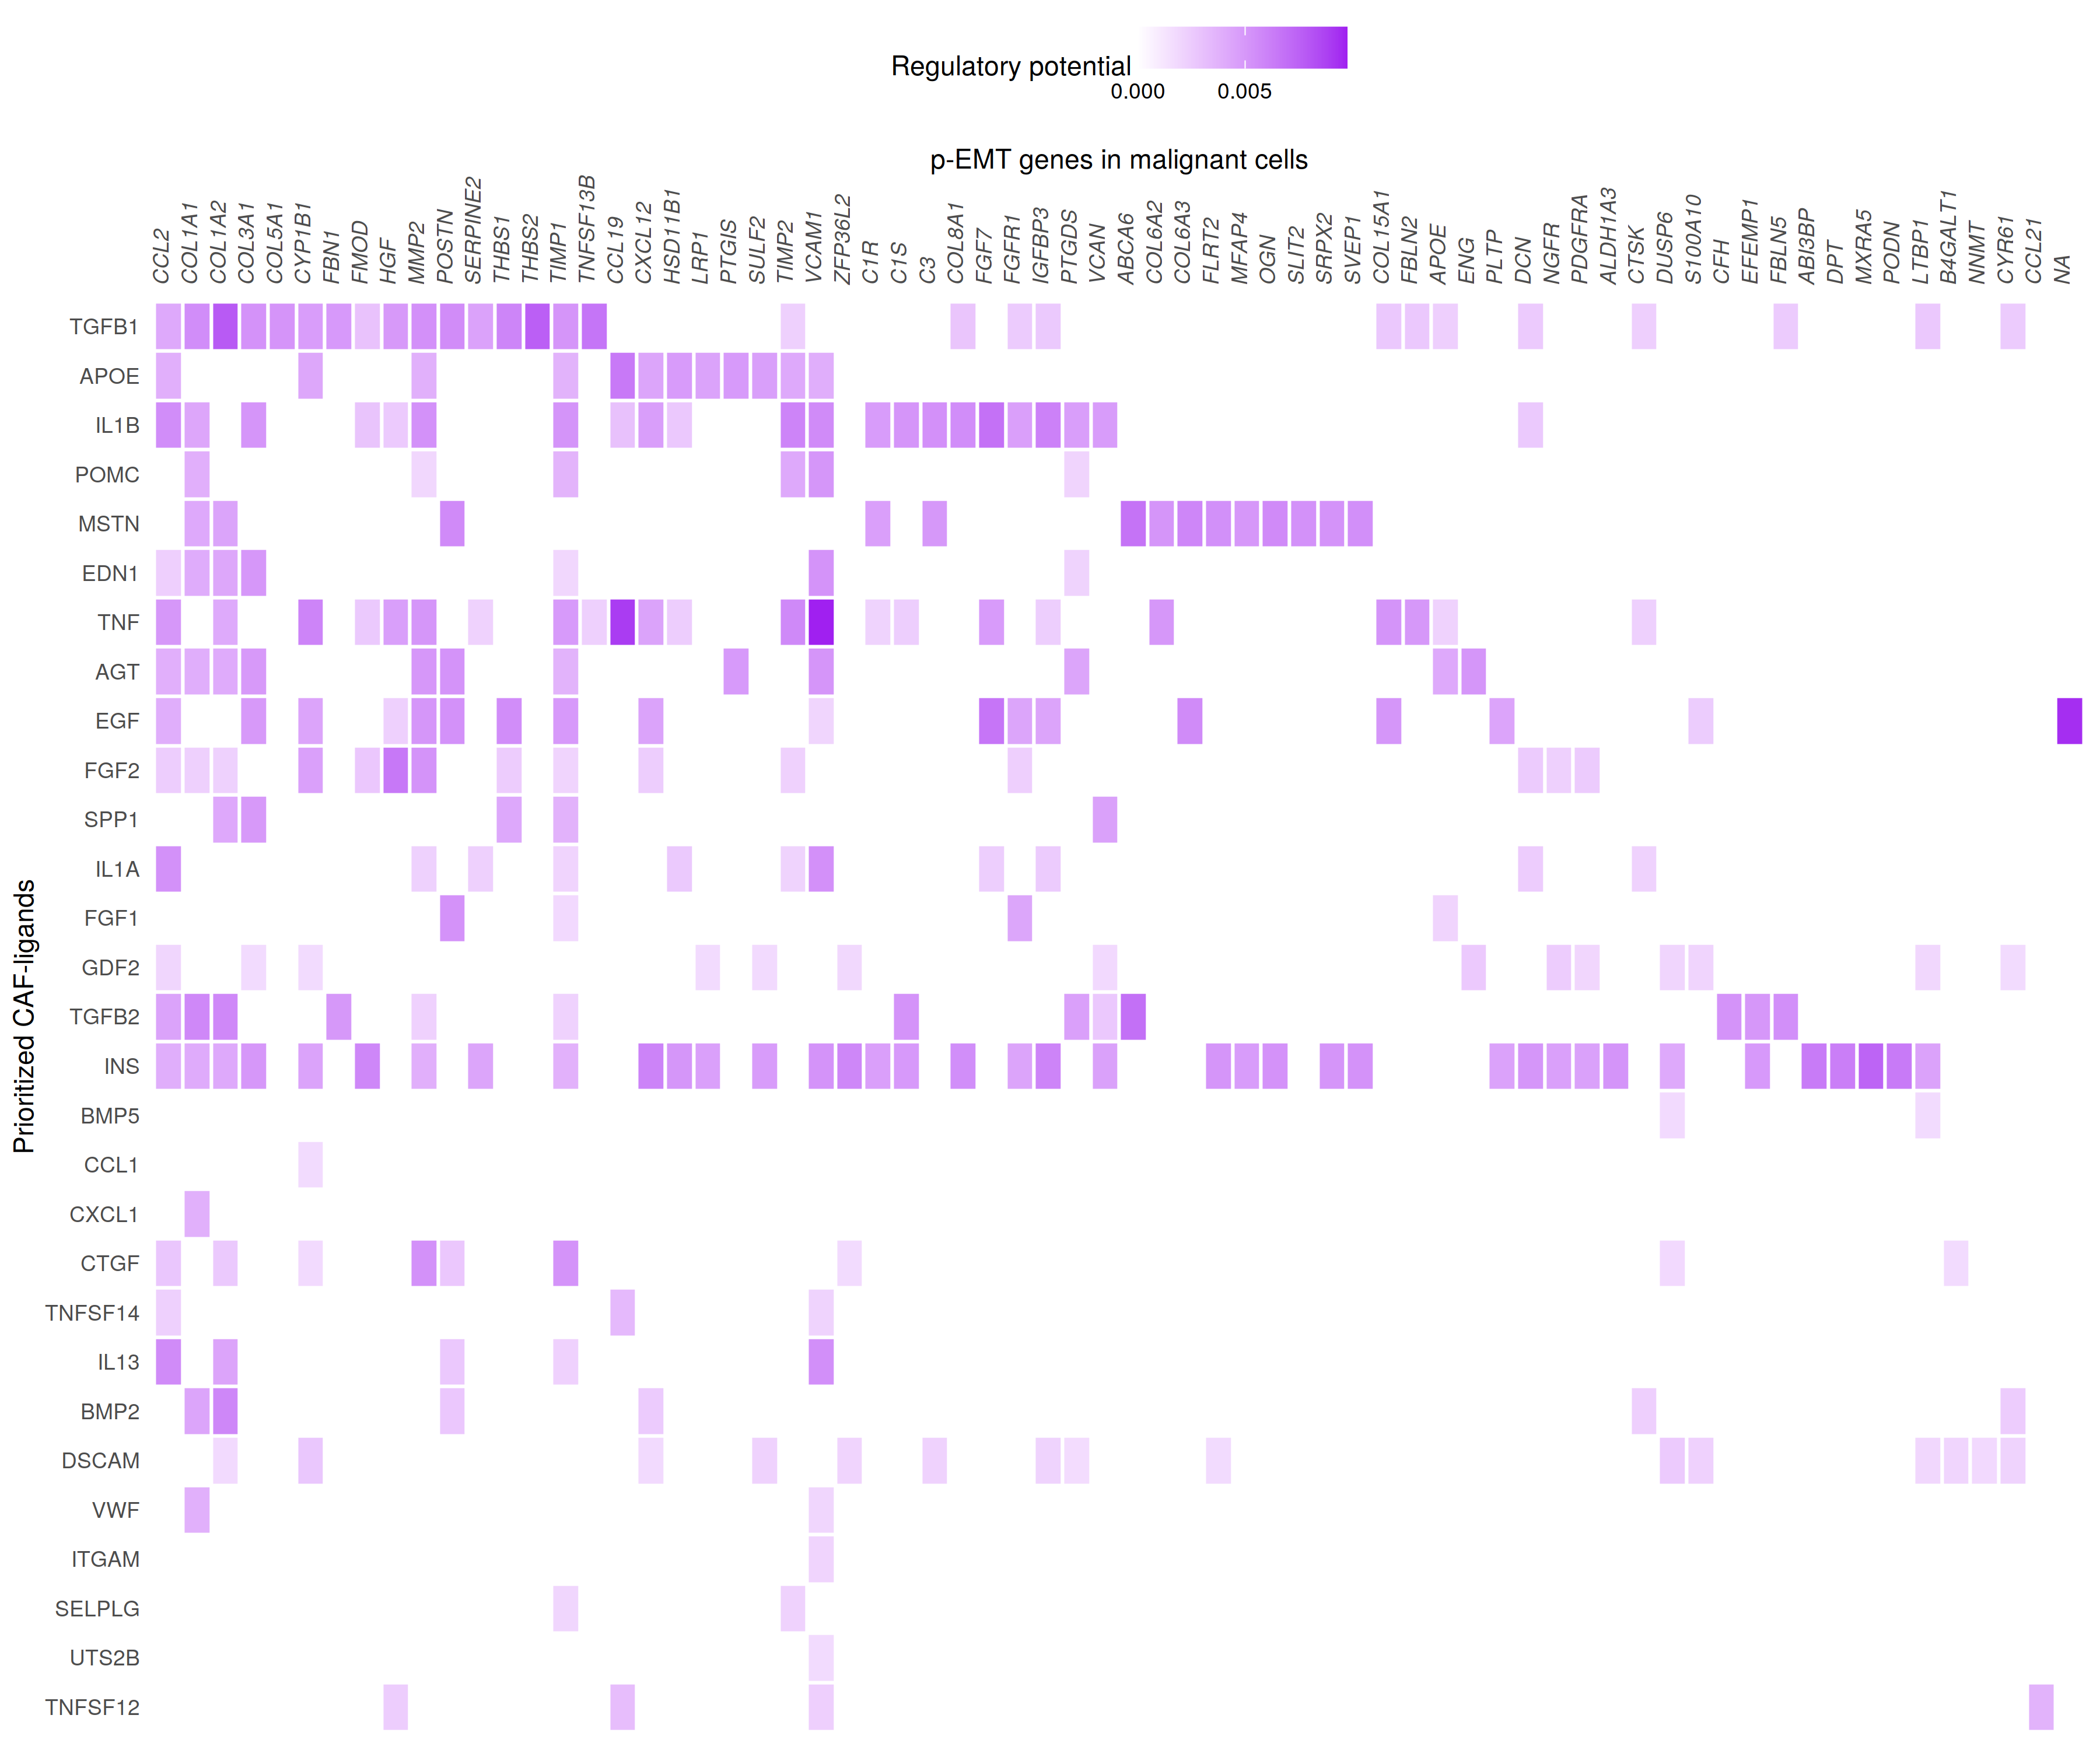

In [196]:
options(repr.plot.width = 12, repr.plot.height = 10, repr.plot.res = 300)

order_ligands = intersect(best_upstream_ligands, colnames(active_ligand_target_links)) %>% rev()
order_targets = active_ligand_target_links_df$target %>% unique()
ov_targets <- intersect(order_targets, rownames(active_ligand_target_links))
ov_ligands <- intersect(order_ligands, colnames(active_ligand_target_links))

vis_ligand_target = active_ligand_target_links[ov_targets,ov_ligands] %>% t()

p_ligand_target_network = vis_ligand_target %>% 
make_heatmap_ggplot("Prioritized CAF-ligands","p-EMT genes in malignant cells", color = "purple",legend_position = "top", x_axis_position = "top",legend_title = "Regulatory potential") + scale_fill_gradient2(low = "whitesmoke",  high = "purple", breaks = c(0,0.005,0.01)) + theme(axis.text.x = element_text(face = "italic"))

p_ligand_target_network

In [ ]:
nichenet_results <- nichenet_main(
    expressed_genes_transmitter = expressed_genes_transmitter,
    expressed_genes_receiver = expressed_genes_receiver,
    genes_of_interest = genes_of_interest,
    background_genes = background_genes,
    signaling_network = list(
        cpdb = NULL,
        evex = list(min_confidence = 1.0)
    ),
    gr_network = list(only_omnipath = TRUE),
    n_top_ligands = 20,
    mlrmbo_optimization_param = list(ncores = 4)
)